In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

In [18]:
df_moves = pd.read_parquet('./data/tramita/exp_moves_iii_vehiculo.parquet')

In [19]:
df_moves.head()

,id_exp,cod_procedimiento,dni,nif,fecha_alta_exp,fecha_registro_exp,codine_provincia,codine_municipio,codine,municipio,provincia,unidad_tramitadora,denom_procedimiento,desc_procedimiento,siaci,consejeria_proc,org_instructor_proc,es_telematica
8217,1064299,844,334825,<NA>,2021-12-21 10:57:35,2021-12-21,13,034,13034,Ciudad Real,Ciudad Real,Direccion general de transicion energetica,Programa MOVES III - Adquisición de vehículos ...,Solicitud de Ayuda MOVES III para la adquisici...,SLN5,Consejeria de desarrollo sostenible,Direccion general de transicion energetica,True
8296,1065133,844,379765,<NA>,2021-12-23 09:19:35,2021-09-28,19,280,19280,Torrejón del Rey,Guadalajara,Direccion general de transicion energetica,Programa MOVES III - Adquisición de vehículos ...,Solicitud de Ayuda MOVES III para la adquisici...,SLN5,Consejeria de desarrollo sostenible,Direccion general de transicion energetica,True
9629,1194601,844,1819757,<NA>,2022-04-01 09:24:54,2022-03-16,19,159,19159,Ledanca,Guadalajara,Direccion general de transicion energetica,Programa MOVES III - Adquisición de vehículos ...,Solicitud de Ayuda MOVES III para la adquisici...,SLN5,Consejeria de desarrollo sostenible,Direccion general de transicion energetica,True
9631,1194608,844,421967,<NA>,2022-04-01 09:27:03,2022-03-16,28,113,28113,Pinto,Madrid,Direccion general de transicion energetica,Programa MOVES III - Adquisición de vehículos ...,Solicitud de Ayuda MOVES III para la adquisici...,SLN5,Consejeria de desarrollo sostenible,Direccion general de transicion energetica,True
9634,1194624,844,1819764,<NA>,2022-04-01 09:33:58,2022-03-17,19,071,19071,"Casar, El",Guadalajara,Direccion general de transicion energetica,Programa MOVES III - Adquisición de vehículos ...,Solicitud de Ayuda MOVES III para la adquisici...,SLN5,Consejeria de desarrollo sostenible,Direccion general de transicion energetica,True


# Create time series

In [20]:
df_moves.set_index('fecha_registro_exp', inplace=True)

In [21]:
ts_moves = df_moves.resample('D').agg(
    total_exp=('id_exp', 'count')
).fillna(0).reset_index()
ts_moves.set_index('fecha_registro_exp', inplace=True)

In [38]:
ts_moves.head()

,total_exp,wn
fecha_registro_exp,,
2021-07-09,1,7.289381
2021-07-10,0,5.392077
2021-07-11,0,9.665604
2021-07-12,0,6.729664
2021-07-13,0,-0.302125


# Day of week

In [42]:
# Add day of week information
ts_moves['day_of_week'] = ts_moves.index.dayofweek

# Average forms by day of week
daily_pattern = ts_moves.groupby('day_of_week')['total_exp'].mean()

In [44]:
print(daily_pattern)

day_of_week
0    5.184049
1    5.956790
2    5.679012
3    5.469136
4    4.877301
5    1.116564
6    1.067485
Name: total_exp, dtype: float64


# Change Point Detection

(<Figure size 2000x500 with 1 Axes>, [<Axes: >])

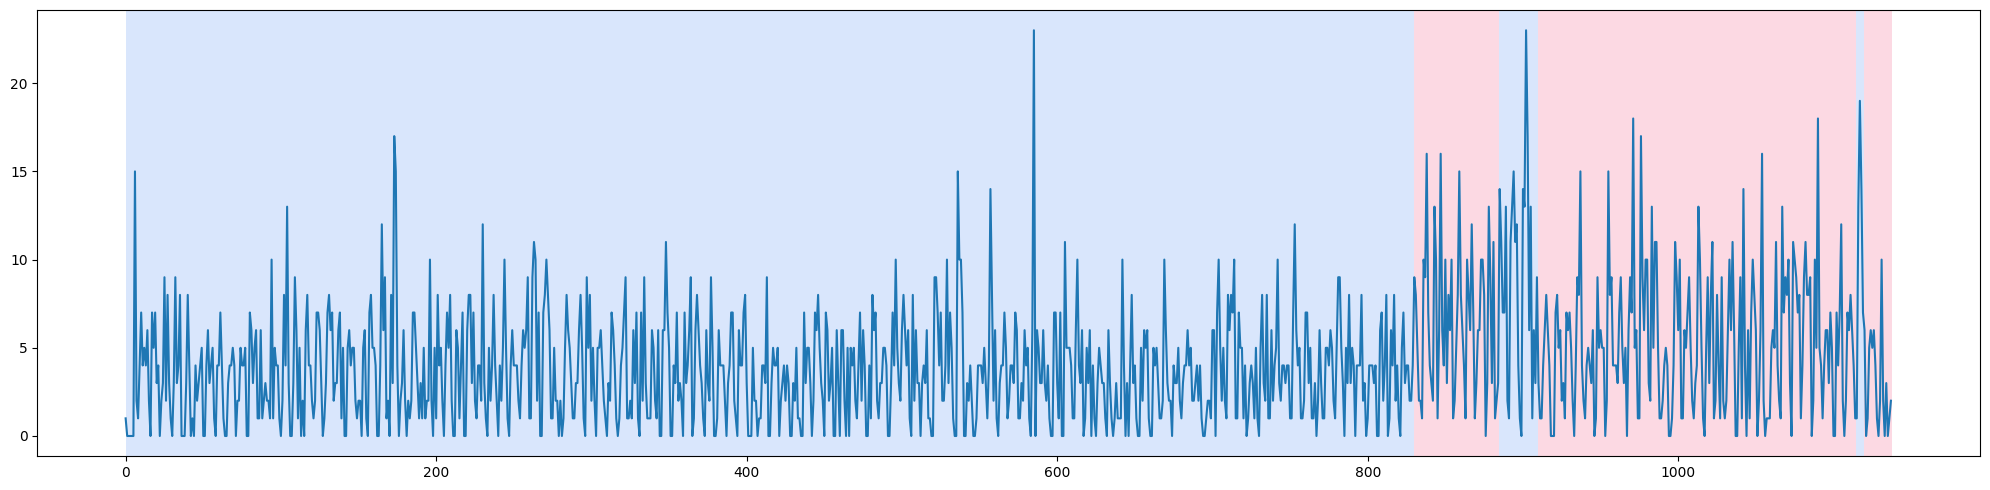

In [48]:
import ruptures as rpt

# Extract data for analysis
signal = ts_moves["total_exp"].values  # Get the data as a numpy array

# Binary Segmentation model with "l2" cost (least squares)
model = rpt.Binseg(model="l2")

# Number of change points to detect
n_bkps = 5

# Fit the model and predict change points
model.fit(signal)
change_points = model.predict(n_bkps=n_bkps)

# Display results
rpt.display(signal, change_points, figsize=(20, 5))

(<Figure size 2000x500 with 1 Axes>, [<Axes: >])

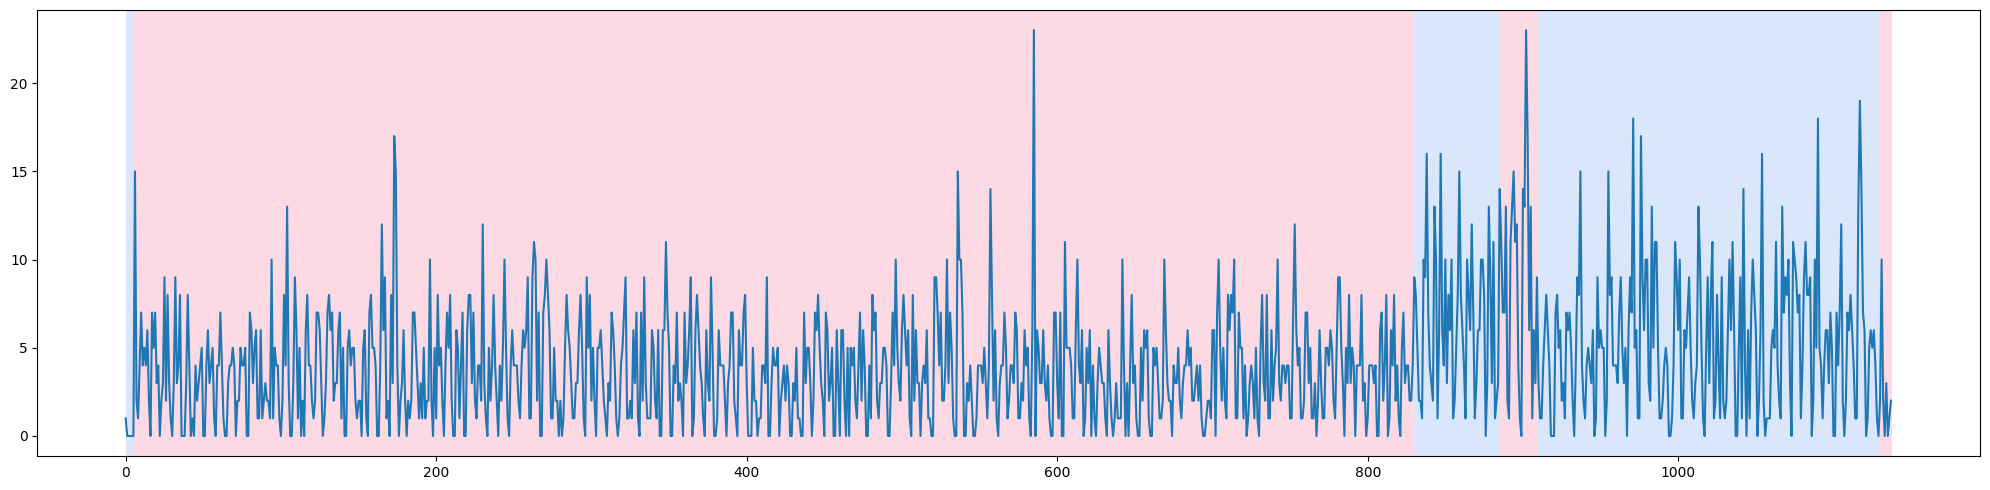

In [49]:
# Binary Segmentation model with "l2" cost (least squares)
model = rpt.Binseg(model="rbf")

# Number of change points to detect
n_bkps = 5

# Fit the model and predict change points
model.fit(signal)
change_points = model.predict(n_bkps=n_bkps)

# Display results
rpt.display(signal, change_points, figsize=(20, 5))

# White noise

In [23]:
ts_moves.describe()

,total_exp
count,1138.000000
mean,4.188928
std,3.512057
min,0.000000
25%,1.000000
50%,4.000000
75%,6.000000
max,23.000000


In [24]:
wn = np.random.normal(loc = ts_moves.total_exp.mean(), scale = ts_moves.total_exp.std(), size = len(ts_moves))

In [25]:
ts_moves['wn'] = wn

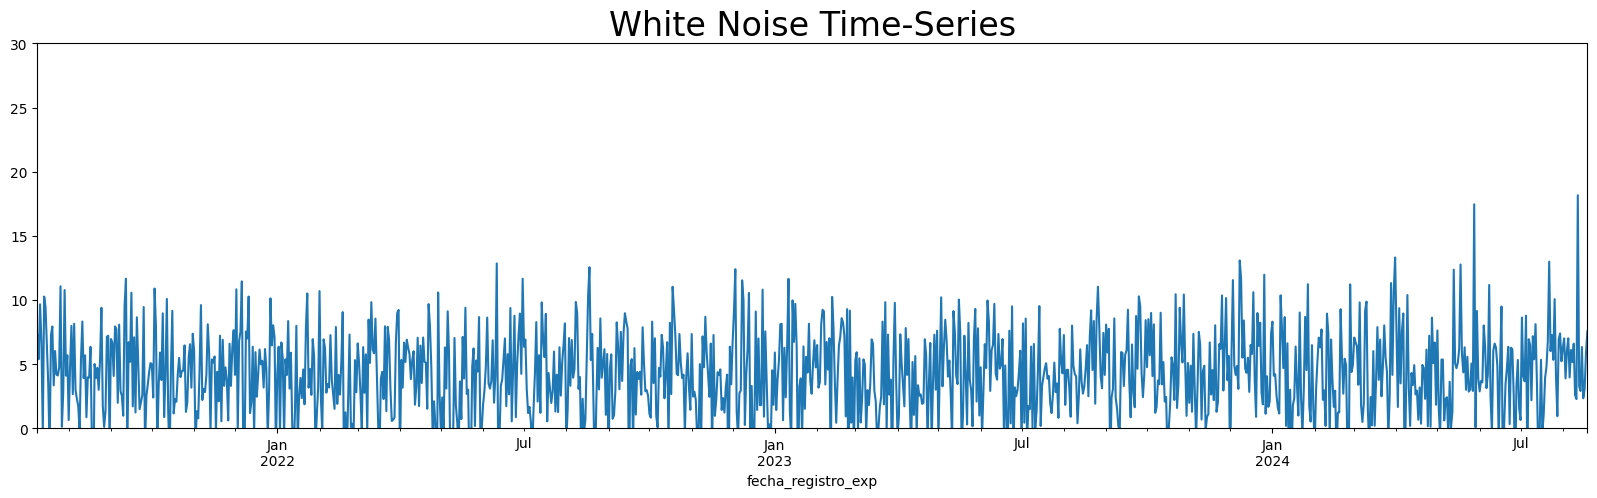

In [33]:
ts_moves.wn.plot(figsize = (20,5))
plt.title("White Noise Time-Series", size= 24)
plt.ylim(0,30)
plt.show()

In [27]:
ts_moves.describe()

,total_exp,wn
count,1138.000000,1138.000000
mean,4.188928,4.274027
std,3.512057,3.421686
min,0.000000,-7.932302
25%,1.000000,1.925669
50%,4.000000,4.179469
75%,6.000000,6.672341
max,23.000000,18.164868


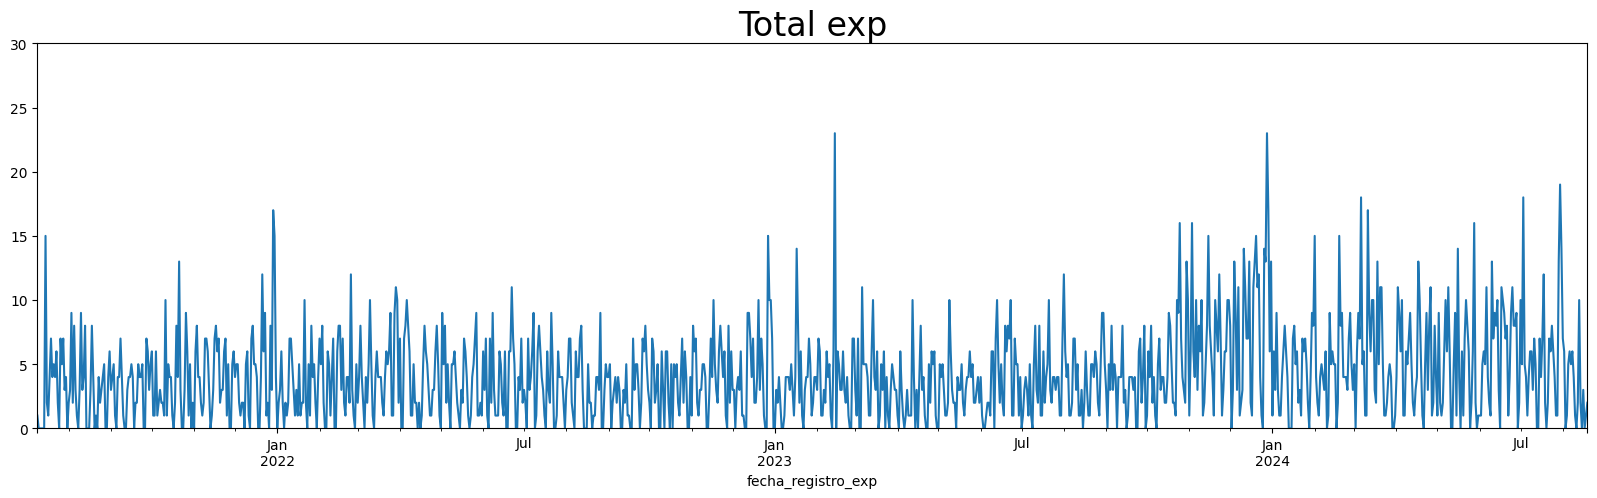

In [34]:
ts_moves.total_exp.plot(figsize=(20,5))
plt.title("Total exp", size = 24)
plt.ylim(0,30)
plt.show()

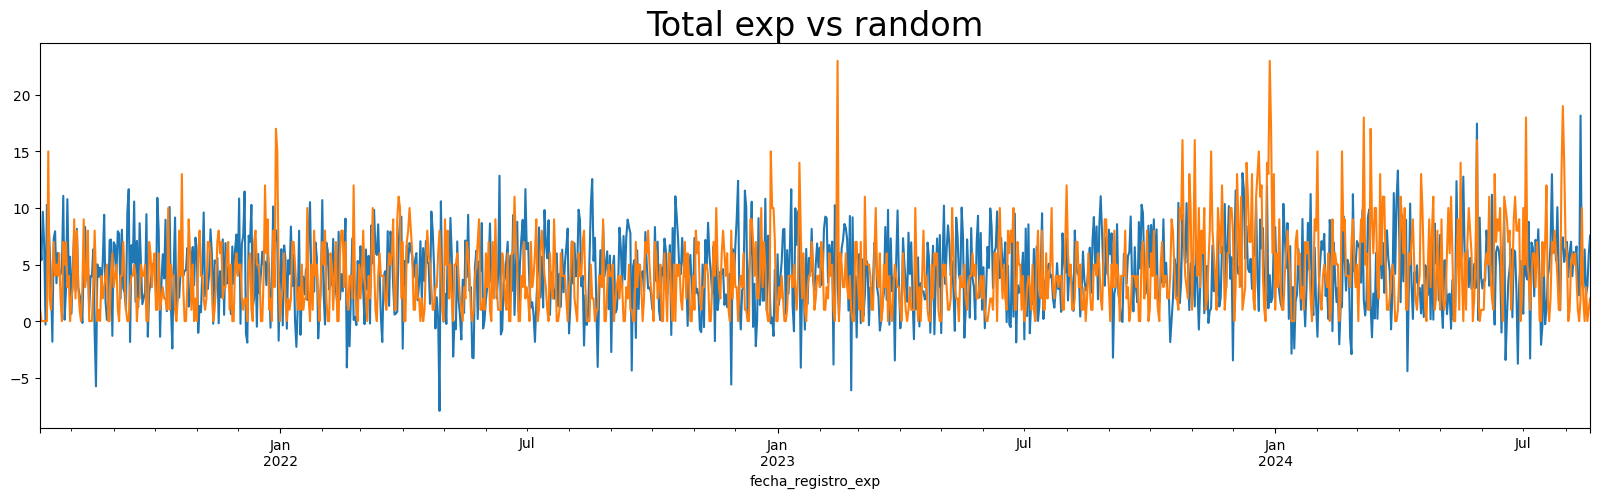

In [29]:
ts_moves.wn.plot(figsize = (20,5))
ts_moves.total_exp.plot()
plt.title("Total exp vs random", size = 24)
plt.show()

# Stationarity

It's particularly good at detecting trending behavior

**ADF Statistic (result[0]):**
This is the test statistic calculated from your data. More negative = stronger evidence for stationarity.Compare this with the critical values

**p-value (result[1]):**
Null hypothesis: Series is non-stationary (has a unit root) 

If p-value < significance level (typically 0.05): Reject null hypothesis Conclude series is stationary

If p-value > 0.05: Fail to reject null hypothesis Series might be non-stationary

**Critical Values (result[4]):**
Usually reported at 1%, 5%, and 10% significance levels If ADF statistic is more negative than critical value: Reject null hypothesis at that ignificance level

In [30]:
sts.adfuller(ts_moves.total_exp)

(-4.413003033656467,
 0.0002814931468243572,
 22,
 1115,
 {'1%': -3.4362284023329313,
  '5%': -2.864135631852894,
  '10%': -2.568151990387902},
 5566.591146495927)

stationary

# Seasonality

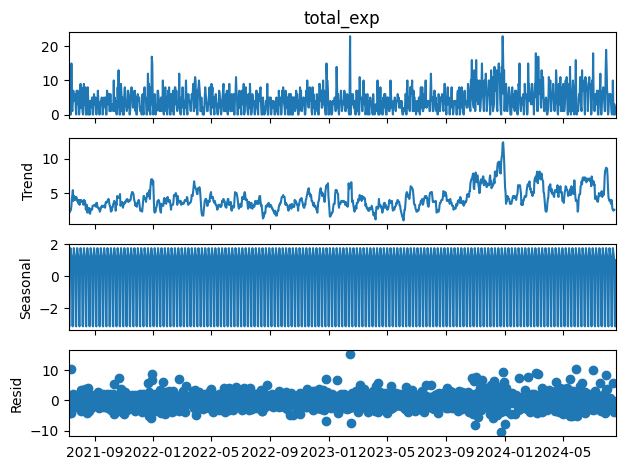

In [31]:
s_dec_additive = seasonal_decompose(ts_moves.total_exp, model = "additive")
s_dec_additive.plot()
plt.show()

In [32]:
s_dec_multiplicative = seasonal_decompose(ts_moves.total_exp, model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [35]:
ts_moves[ts_moves.total_exp == 0].count()

total_exp    155
wn           155
dtype: int64

# ACF Auto correlation graph

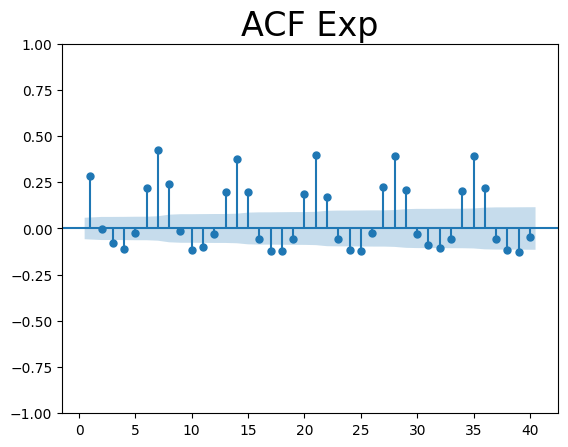

In [36]:
sgt.plot_acf(ts_moves.total_exp, lags = 40, zero = False)
plt.title("ACF Exp", size = 24)
plt.show()

blue area is significance, inside blue: not significant.